In [ ]:
# --- 1. 라이브러리 및 모듈 임포트 ---

# 데이터 처리 라이브러리
import pandas as pd
import numpy as np

# 데이터 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 모델 및 평가 도구
import lightgbm as lgb
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# 시스템 및 경로 관련 라이브러리
import sys
import os
from datetime import datetime
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (baseline_code.ipynb 참고)
# Colab 또는 로컬 환경에 맞게 경로를 설정해야 할 수 있습니다.
import matplotlib.font_manager as fm
try:
    fe = fm.FontEntry(
        fname=r'../../font/NanumFont/NanumGothic.ttf',
        name='NanumGothic')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})
    plt.rc('font', family='NanumGothic')
except FileNotFoundError:
    print("나눔고딕 폰트를 찾을 수 없어 기본 폰트로 설정됩니다.")
    pass

In [ ]:
# --- 2. 경로 설정 및 커스텀 로거 임포트 ---

# 현재 노트북 파일의 위치를 기준으로 프로젝트 루트 경로를 설정합니다.
# (예: notebooks 폴더에 있다면 ../../src 가 맞습니다)
try:
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../../src/log"))
    sys.path.insert(0, src_path)
    from logger import Logger
    print("Logger 모듈 로드 성공.")
    
except ImportError:
    print("[오류] Logger 모듈을 찾을 수 없습니다. src/log/logger.py 경로를 확인해주세요.")
    # Logger가 없어도 코드가 중단되지 않도록 임시 클래스 정의
    class Logger:
        def __init__(self, *args, **kwargs): pass
        def write(self, message, **kwargs): print(message)

Logger 모듈 로드 성공.


In [38]:
# --- 3. 로거 및 경로 초기화 ---

# 로그 파일이 저장될 경로 설정
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_DIR         = '../../data/logs/price_prediction_logs'
LOG_FILENAME    = f"price_prediction_{timestamp}.log"
LOG_PATH        = os.path.join(LOG_DIR, LOG_FILENAME)

# Directory 생성
os.makedirs(LOG_DIR, exist_ok=True)

# Logger 인스턴스 생성
logger = Logger(log_path=LOG_PATH)

# 데이터 및 제출 파일 경로 설정
DATA_PATH = '../../data/processed/cleaned_data/test_clean.csv'
SUBMISSION_DIR = '../../data/processed/submissions'
SUBMISSION_FILENAME = 'price_prediction_submission.csv'
SUBMISSION_PATH = os.path.join(SUBMISSION_DIR, SUBMISSION_FILENAME)

logger.write("="*50)
logger.write(">> 아파트 가격 예측 모델링 시작")

2025-07-14 08:40:48 | ==================================================
2025-07-14 08:40:48 | >> 아파트 가격 예측 모델링 시작


In [39]:
# --- 4. 데이터 로드 ---

logger.write(">> 정제된 Train/Test 데이터를 로드합니다...")
try:
    # 학습 데이터와 테스트 데이터를 각각 로드
    train_df_clean = pd.read_csv('../../data/processed/cleaned_data/train_clean.csv')
    test_df_clean = pd.read_csv('../../data/processed/cleaned_data/test_clean.csv')
    
    # 두 데이터를 합치기 전에 isTest 컬럼으로 구분
    train_df_clean['isTest'] = 0
    test_df_clean['isTest'] = 1
    
    # 하나의 데이터프레임으로 합침
    df = pd.concat([train_df_clean, test_df_clean])
    
    logger.write(">> 데이터 로드 및 병합 완료.")
except FileNotFoundError:
    logger.write(f">> [오류] train_clean.csv 또는 test_clean.csv 파일을 찾을 수 없습니다.", print_error=True)
    df = None

2025-07-14 08:40:48 | >> 정제된 Train/Test 데이터를 로드합니다...
2025-07-14 08:40:50 | >> 데이터 로드 및 병합 완료.


2025-07-14 08:40:50 | >> EDA: 데이터 정보 및 통계 요약을 시작합니다...
2025-07-14 08:40:50 | >> EDA: 데이터 정보 및 통계 요약
2025-07-14 08:40:50 | 데이터 크기: (1107114, 30)
2025-07-14 08:40:50 | 컬럼 목록: ['계약일자', '계약년월', '계약년도', '계약월', '자치구', '법정동', '강남3구여부', '전용면적', '층', '홈페이지유무', '사용허가여부', '연식', '브랜드등급', '아파트이름길이', '지하철최단거리', '반경_1km_지하철역_수', '반경_500m_지하철역_수', '반경_300m_지하철역_수', '버스최단거리', '반경_1km_버스정류장_수', '반경_500m_버스정류장_수', '반경_300m_버스정류장_수', '총인구수', '성비(남/여)', 'loanrate_1m', 'loanrate_3m', 'loanrate_6m', 'loanrate_12m', 'target', 'isTest']
2025-07-14 08:40:50 | 데이터 타입:
계약일자                object
계약년월                 int64
계약년도                 int64
계약월                  int64
자치구                 object
법정동                 object
강남3구여부               int64
전용면적               float64
층                    int64
홈페이지유무               int64
사용허가여부               int64
연식                   int64
브랜드등급               object
아파트이름길이              int64
지하철최단거리             object
반경_1km_지하철역_수       object
반경_500m_지하철역_수      

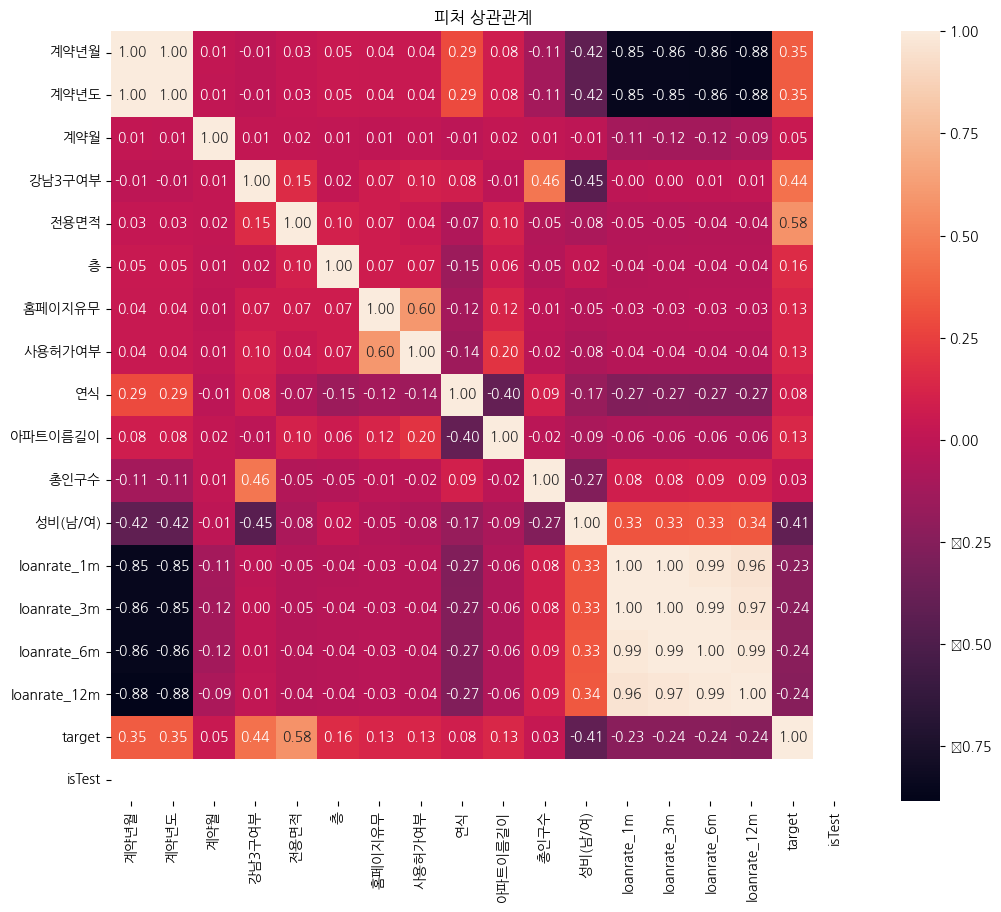

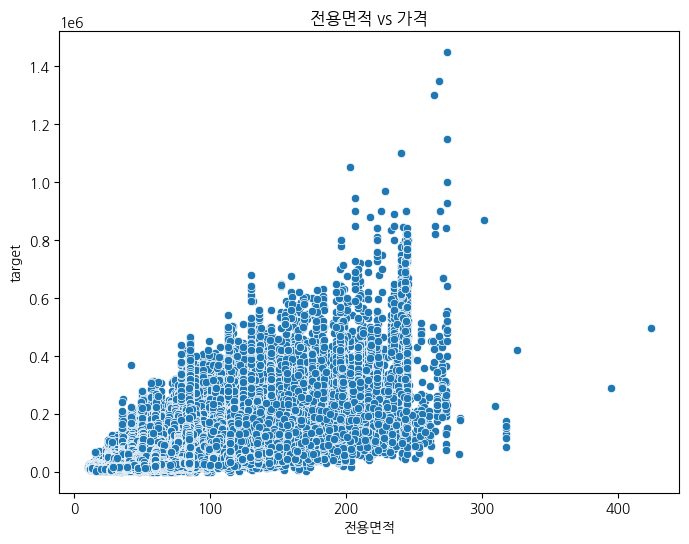

2025-07-14 08:40:52 | >> EDA 완료


In [40]:
# --- 5. EDA 추가 ---

logger.write(">> EDA: 데이터 정보 및 통계 요약을 시작합니다...")

if df is not None:
    logger.write(">> EDA: 데이터 정보 및 통계 요약")
    # 데이터 정보 출력
    logger.write(f"데이터 크기: {df.shape}")
    logger.write(f"컬럼 목록: {df.columns.tolist()}")
    logger.write(f"데이터 타입:\n{df.dtypes}")
    
    # 통계 요약 출력
    stats = df.describe()
    logger.write(f"\n통계 요약:\n{stats}")
    
if train_df_clean is not None:
    logger.write(">> EDA: 상관관계 히트맵 및 전용면적 vs 가격 산점도 시각화")
    # 상관관계 히트맵
    plt.figure(figsize=(12,10))
    sns.heatmap(train_df_clean.corr(), annot=True, fmt=".2f")
    plt.title('피처 상관관계')
    plt.show()
    # 전용면적 vs target 산점도
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='전용면적', y='target', data=train_df_clean)
    plt.title('전용면적 vs 가격')
    plt.show()
    logger.write(">> EDA 완료")

2025-07-14 08:40:52 | >> 주요 변수 데이터 분포 시각화를 시작합니다...


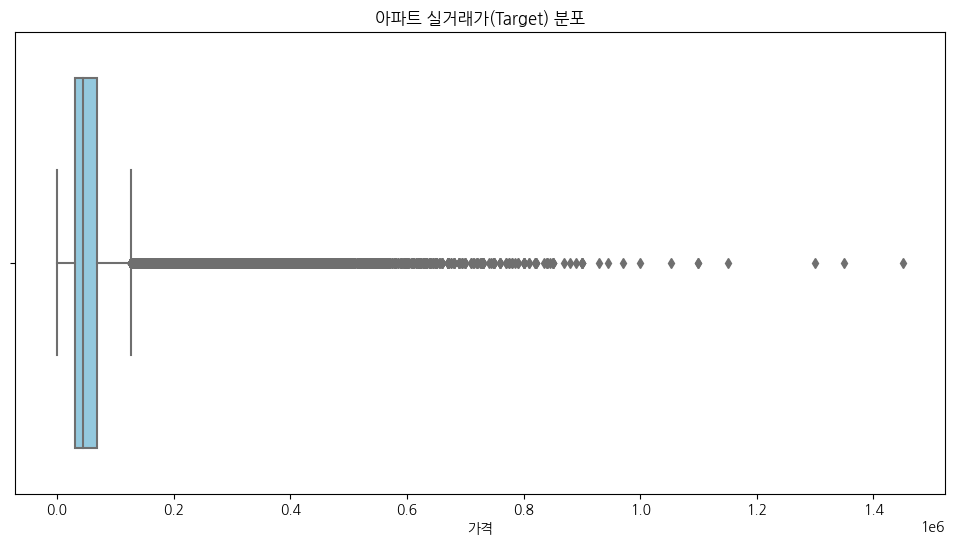

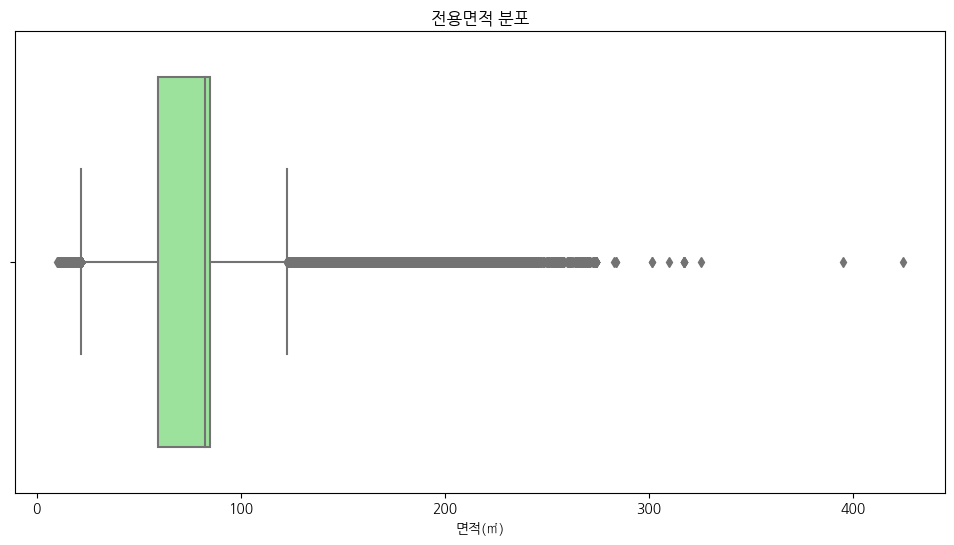

In [41]:
# --- 5. 데이터 시각화 ---

if df is not None:
    try:
        logger.write(">> 주요 변수 데이터 분포 시각화를 시작합니다...")
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=train_df_clean, x='target', color='skyblue')
        plt.title('아파트 실거래가(Target) 분포')
        plt.xlabel('가격')
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='전용면적', color='lightgreen') # 컬럼명 수정
        plt.title('전용면적 분포')
        plt.xlabel('면적(㎡)')
        plt.show()
        
    except Exception as e:
        logger.write(f">> [오류] 데이터 시각화 중 문제 발생: {e}", print_error=True)

In [42]:
# --- 6. 특성 공학 (Feature Engineering) ---

if df is not None:
    try:
        logger.write(">> 특성 공학을 통해 파생 변수를 생성합니다...")

        # 0. 계약일자 -> 계약년, 계약월, 계약분기
        df['계약일자'] = pd.to_datetime(df['계약일자'])
        df['계약년']  = df['계약일자'].dt.year
        df['계약월']  = df['계약일자'].dt.month
        df['계약분기']= df['계약일자'].dt.quarter

        # 계약일자 컬럼은 모델 입력에서 제외
        df.drop(columns=['계약일자'], inplace=True)

        # 1. '신축여부' 파생변수 생성 (연식 10년 이하를 신축으로 판단)
        df['신축여부'] = df['연식'].apply(lambda x: 1 if x <= 10 else 0)

        # 2. 교통 관련 변수들을 숫자형으로 변환
        traffic_cols = [
            '지하철최단거리','반경_1km_지하철역_수','반경_500m_지하철역_수','반경_300m_지하철역_수',
            '버스최단거리','반경_1km_버스정류장_수','반경_500m_버스정류장_수','반경_300m_버스정류장_수'
        ]
        for col in traffic_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        logger.write(">> 파생변수 생성 및 타입 변환 완료.")
        
    except Exception as e:
        logger.write(f">> [오류] 특성 공학 중 문제 발생: {e}", print_error=True)

2025-07-14 08:40:53 | >> 특성 공학을 통해 파생 변수를 생성합니다...
2025-07-14 08:40:55 | >> 파생변수 생성 및 타입 변환 완료.


In [43]:
# --- 7. 피처 선택 및 데이터 분리 ---

logger.write(">> 피처 선택 및 데이터 분리를 시작합니다...")

# isTest 컬럼을 사용해 train/test 데이터 분리
if df is not None:
    try:
        # isTest 컬럼을 사용해 train/test 데이터 분리
        train_df = df[df['isTest']==0].drop('isTest',axis=1).copy()
        test_df  = df[df['isTest']==1].drop('isTest',axis=1).copy()
        logger.write(">> Train/Test 데이터 분리 완료.")

        # 예측에 사용할 피처(X)와 타겟(y) 정의
        features = [col for col in train_df.columns if col != 'target']
        
        X_train_raw = train_df[features]
        y_train = train_df['target']
        X_test_raw = test_df[features]

        # 범주형(object) 피처 자동 탐지
        categorical_features = X_train_raw.select_dtypes(include=['object']).columns.tolist()
        
        logger.write(f">> 예측에 사용할 피처 개수: {len(features)}개")
        logger.write(f">> 범주형 피처: {categorical_features}")
        
    except Exception as e:
        logger.write(f">> [오류] 피처 선택 및 데이터 분리 중 문제 발생: {e}", print_error=True)

2025-07-14 08:40:55 | >> 피처 선택 및 데이터 분리를 시작합니다...
2025-07-14 08:40:55 | >> Train/Test 데이터 분리 완료.
2025-07-14 08:40:55 | >> 예측에 사용할 피처 개수: 30개
2025-07-14 08:40:55 | >> 범주형 피처: ['자치구', '법정동', '브랜드등급']


In [44]:
# --- 8. 범주형 피처 Label Encoding ---

if 'X_train_raw' in locals():
    try:
        label_encoders = {}
        for col in categorical_features:
            le = LabelEncoder()
            all_vals = pd.concat([X_train_raw[col], X_test_raw[col]]).astype(str)
            le.fit(all_vals)
            X_train_raw[col] = le.transform(X_train_raw[col].astype(str))
            X_test_raw[col]  = le.transform(X_test_raw[col].astype(str))
            label_encoders[col] = le
        logger.write(">> 범주형 Label Encoding 완료.")
        
    except Exception as e:
        logger.write(f">> [오류] Label Encoding 중 문제 발생: {e}", print_error=True)

2025-07-14 08:40:55 | >> 범주형 Label Encoding 완료.


2025-07-14 08:40:56 | >> LightGBM 모델 학습 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2820
[LightGBM] [Info] Number of data points in the train set: 878273, number of used features: 30
[LightGBM] [Info] Start training from score 57582.439147
2025-07-14 08:40:57 | >> Validation RMSE: 12724.0094, MAE: 7830.7680, R2: 0.9234


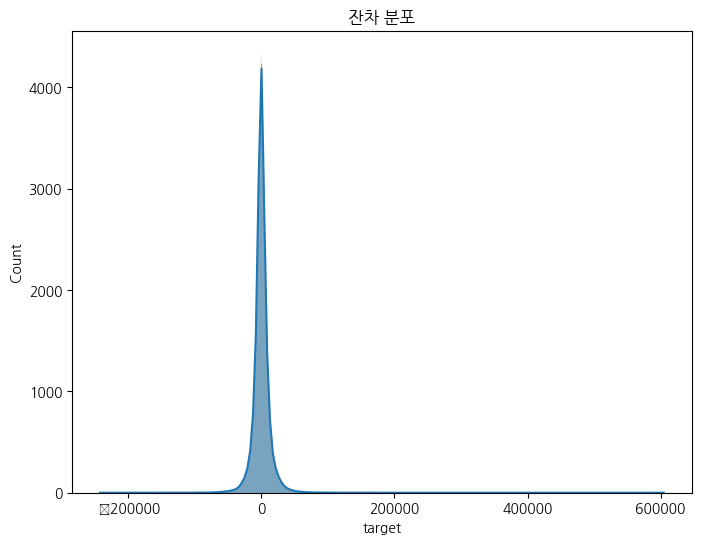

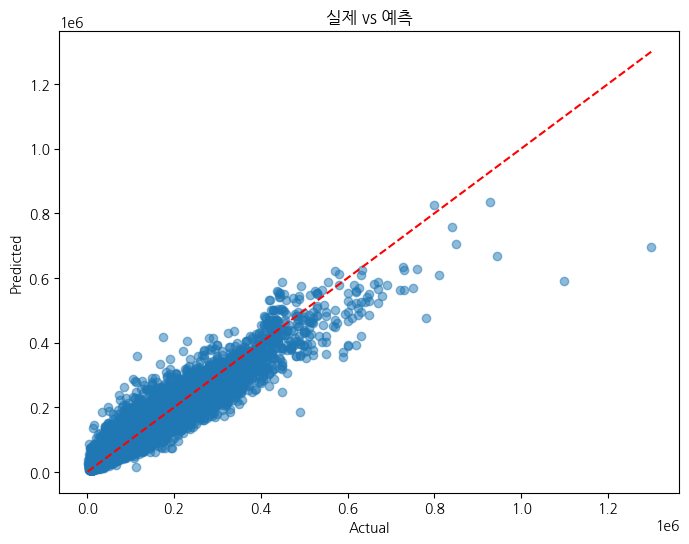

In [45]:
# --- 9. 모델 학습 및 기본 평가 ---

if 'X_train_raw' in locals():
    try:
        X_train, X_val, y_train_split, y_val_split = train_test_split(
            X_train_raw, y_train, test_size=0.2, random_state=42
        )

        logger.write(">> LightGBM 모델 학습 시작")
        lgbm = lgb.LGBMRegressor(random_state=42)
        lgbm.fit(X_train, y_train_split)
        y_pred = lgbm.predict(X_val)

        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        mae  = mean_absolute_error(y_val_split, y_pred)
        r2   = r2_score(y_val_split, y_pred)
        logger.write(f">> Validation RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

        # 잔차 분포 시각화
        residuals = y_val_split - y_pred
        plt.figure(figsize=(8,6))
        sns.histplot(residuals, kde=True)
        plt.title('잔차 분포')
        plt.show()

        # 실제 vs 예측 산점도
        plt.figure(figsize=(8,6))
        plt.scatter(y_val_split, y_pred, alpha=0.5)
        plt.plot([y_val_split.min(), y_val_split.max()],
                 [y_val_split.min(), y_val_split.max()],
                 'r--')
        plt.title('실제 vs 예측')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

    except Exception as e:
        logger.write(f">> [오류] 모델 학습/평가 중 문제 발생: {e}", print_error=True)

In [46]:
# --- 10. 교차 검증 및 하이퍼파라미터 탐색 ---

if 'X_train_raw' in locals():
    try:
        logger.write(">> 교차 검증 및 하이퍼파라미터 탐색 시작")
        param_dist = {
            'num_leaves':    [31, 50, 70],
            'learning_rate':[0.1,0.01,0.001],
            'max_depth':     [-1, 10, 20]
        }
        rs = RandomizedSearchCV(
            estimator=lgb.LGBMRegressor(random_state=42),
            param_distributions=param_dist,
            n_iter=10, cv=5,
            scoring='neg_mean_squared_error',
            verbose=1, random_state=42
        )
        rs.fit(X_train_raw, y_train)
        logger.write(f">> 최적 파라미터: {rs.best_params_}")

        # CV 기반 평가
        y_cv_pred = rs.best_estimator_.predict(X_val)
        rmse_cv = np.sqrt(mean_squared_error(y_val_split, y_cv_pred))
        logger.write(f">> CV 모델 RMSE: {rmse_cv:.4f}")
        
    except Exception as e:
        logger.write(f">> [오류] 하이퍼파라미터 탐색 중 문제 발생: {e}", print_error=True)

2025-07-14 08:40:59 | >> 교차 검증 및 하이퍼파라미터 탐색 시작
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2630
[LightGBM] [Info] Number of data points in the train set: 878273, number of used features: 30
[LightGBM] [Info] Start training from score 56623.671767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2683
[LightGBM] [Info] Number of data points in the train set: 878273, number of used features: 30
[LightGBM] [Info] Start training from score 50092.188647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead

In [ ]:
# --- 11. 최종 예측 및 제출 파일 생성 ---

if 'X_train_raw' in locals():
    logger.write(">> 최종 모델 학습 및 제출 파일 생성 시작")
    try:
        final_model = lgb.LGBMRegressor(random_state=42)
        final_model.fit(X_train_raw, y_train)

        # 모델 저장
        import joblib
        joblib.dump(final_model, '../../model/final_price_model.pkl')
        logger.write(">> 모델 저장 완료: final_price_model.pkl")

        # 테스트 예측 및 제출 파일
        final_preds = final_model.predict(X_test_raw)
        try:
            sub = pd.read_csv(SUBMISSION_PATH)
            sub['target'] = final_preds
            sub.to_csv(SUBMISSION_PATH, index=False)
        except FileNotFoundError:
            logger.write(">> sample_submission.csv 미발견, 새로 생성", print_error=True)
            pd.DataFrame({'target': final_preds}).to_csv(SUBMISSION_PATH, index=False)
        logger.write(f">> 제출 파일 생성 완료: {SUBMISSION_PATH}")

    except Exception as e:
        logger.write(f">> [오류] 제출파일 생성 중: {e}", print_error=True)

logger.write(">> 전체 프로세스 완료")

2025-07-14 08:42:04 | >> 최종 모델 학습 및 제출 파일 생성 시작
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2816
[LightGBM] [Info] Number of data points in the train set: 1097842, number of used features: 30
[LightGBM] [Info] Start training from score 57571.638850
2025-07-14 08:42:05 | >> 모델 저장 완료: final_price_model.pkl
2025-07-14 08:42:05 | >> 제출 파일 생성 완료: ../../data/processed/submissions/price_prediction_submission.csv
2025-07-14 08:42:05 | >> 전체 프로세스 완료
